In [2]:
#import main libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pip install seaborn
import seaborn as sns

# Graphics in retina format are more sharp and legible

from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
#import libraries for making a pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.compose import make_column_selector
from sklearn.model_selection import cross_val_score

In [4]:
#import data to dataframe
df = pd.read_csv("datasets/BankChurners.csv")
#drop last 2 columns as not required
df.drop(labels={'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'},axis=1,inplace = True)
df.shape#(10127, 21)

(10127, 21)

In [5]:

#create numerical target var
df['Attrition_Flag']=df['Attrition_Flag'].apply(lambda x: 0 if x=='Existing Customer' else 1)
df_copy=df.copy()
df_copy['Attrition_Flag'].value_counts()

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

#  Build a Pipeline for the following order
- impute values(missing or outlier)
- encode variabes (categorical-onehot, ordinal - ordinal)
- feature creation and selection
- model fit and predict

In [6]:
#lets see if there are any more columns with missing values 
null_columns=df_copy.columns[df_copy.isnull().any()]
df_copy.isnull().sum()
#no null values

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [7]:
df_copy=df_copy.drop('CLIENTNUM',axis=1)
df_copy.shape
#(10127, 20)

(10127, 20)

In [8]:
#cnvert all categorical datatype as category
cat_collist=[         
#'Months_Inactive_12_mon',  #consider the var as numeric
#'Contacts_Count_12_mon',   #consider the var as numeric
'Total_Relationship_Count',  
'Gender',                   
'Dependent_count',          
'Marital_Status',            
'Card_Category']
ord_collist=['Education_Level',        
'Income_Category']
df_copy[cat_collist] = df_copy[cat_collist].astype('category')

In [9]:
#convert ordinal data using Ordinalencoder as it is diffcult to use in pipeline

df_copy[['Education_Level']] = OrdinalEncoder(categories=
               [['Unknown','Uneducated','High School','Graduate','College','Post-Graduate','Doctorate']]).fit_transform(df_copy[['Education_Level']])
df_copy[['Income_Category']] = OrdinalEncoder(categories=
               [['Unknown','Less than $40K','$40K - $60K','$60K - $80K','$80K - $120K','$120K +']]).fit_transform(df_copy[['Income_Category']])

df_copy.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,2.0,Married,3.0,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,3.0,Single,1.0,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,3.0,Married,4.0,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,2.0,Unknown,1.0,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,1.0,Married,3.0,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [10]:
#Feature pipeline here
#based on univariate DA

df_copy['MOB_lbl'] = pd.cut(df_copy['Months_on_book'], bins=[0, 24, 36, float('Inf')], 
                              labels=['<=24', '24-36', '>36'],include_lowest = True)
df_copy['Ina_12_cnt_lbl'] = pd.cut(df_copy['Months_Inactive_12_mon'], bins=[0, 3, float('Inf')],
                                     labels=['<=3', '>3'],include_lowest = True)
df_copy['Credit_Limit_lbl'] = pd.cut(df_copy['Credit_Limit'], bins=[0, 5000, 10000,15000,30000,float('Inf')], 
                                       labels=['0-5k', '5-10k','10-15k','15-30k','>30k'],include_lowest = True)
df_copy['util_lbl'] = pd.cut(df_copy['Avg_Utilization_Ratio'], bins=[0, 0.2,0.5, float('Inf')], 
                                       labels=['0-0.2','0.2-0.5','>0.5'],include_lowest = True)
df_copy['Trans_Amt_lbl'] = pd.cut(df_copy['Total_Trans_Amt'], bins=[0, 5000, 12500, float('Inf')], 
                                       labels=['0-5k','5-12.5k','>12.5k'],include_lowest = True)
df_copy['Trans_Ct_lbl'] = pd.cut(df_copy['Total_Trans_Ct'], bins=[0, 50,100, float('Inf')], 
                                       labels=['0-50','50-100','>100'],include_lowest = True)

In [11]:
# Remove multi collinear variable

In [12]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  int64   
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  category
 4   Education_Level           10127 non-null  float64 
 5   Marital_Status            10127 non-null  category
 6   Income_Category           10127 non-null  float64 
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  category
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

In [13]:
#create test and train data
df_train_data,df_test_data,df_train_target,df_test_target = train_test_split(df_copy.drop('Attrition_Flag',axis=1),df_copy['Attrition_Flag'],test_size=0.3,
                                                                           random_state=42,stratify=df_copy['Attrition_Flag'])
print(df_train_data.shape,' and ',df_test_data.shape)
#(7088, 19)  and  (3039, 19)

(7088, 25)  and  (3039, 25)


In [14]:
df_train_data.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,MOB_lbl,Ina_12_cnt_lbl,Credit_Limit_lbl,util_lbl,Trans_Amt_lbl,Trans_Ct_lbl
8948,44,F,3,1.0,Married,1.0,Blue,36,2,3,...,7632,95,0.532,0.275,24-36,<=3,5-10k,0.2-0.5,5-12.5k,50-100
6665,39,F,1,3.0,Single,0.0,Blue,34,3,1,...,4809,87,0.740,0.873,24-36,<=3,0-5k,>0.5,0-5k,50-100
7119,52,M,1,0.0,Married,4.0,Blue,36,4,2,...,4286,72,0.636,0.107,24-36,<=3,10-15k,0-0.2,0-5k,50-100
2257,34,M,0,3.0,Married,2.0,Blue,17,4,1,...,1868,43,0.344,0.793,<=24,<=3,0-5k,>0.5,0-5k,0-50
3461,47,M,5,6.0,Single,1.0,Blue,36,3,1,...,4252,70,0.591,0.150,24-36,<=3,5-10k,0-0.2,0-5k,50-100


# PIPELINE START

# Encoding categorical /ordinal /Numerical data
- Ordinal encoder converts ordinal column to discrete Numeric values (rank order). Output is single column
- OneHotEncoder converts 1 caegorical column to "number of categories(n-level)" columns. drop='first' removes 1st column to avoid collinearity in model(dummy variable trap). 
- Numerical values can be converted to categorical (bins) - equal sized ranges (eg:-deciles) or equally distributed data ranges(each bin contains equal number of values). We can also manually create categorical bins based on business knowledge or observation from EDA step


In [15]:
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False,handle_unknown='ignore',drop='first'))
])

In [16]:
#numerical transformer for numerical data
Num_trf = Pipeline([
    ('scale',MinMaxScaler())
])

In [17]:
trf1 = ColumnTransformer([
        ("pass", "passthrough", make_column_selector(dtype_exclude="category")),
        ("cat", cat_pipeline, make_column_selector(dtype_include="category"))
])

In [18]:
# 4) Feature selection
trf2 = SelectKBest(score_func=chi2,k=5)

In [19]:
# train the model
trf3 = DecisionTreeClassifier(min_samples_leaf=100,max_depth=5,random_state=42,criterion='entropy')

In [20]:
df_new=pd.DataFrame(trf1.fit_transform(df_train_data),columns=trf1.get_feature_names_out())
df_new

,pass__Customer_Age,pass__Education_Level,pass__Income_Category,pass__Months_on_book,pass__Months_Inactive_12_mon,pass__Contacts_Count_12_mon,pass__Credit_Limit,pass__Total_Revolving_Bal,pass__Avg_Open_To_Buy,pass__Total_Amt_Chng_Q4_Q1,...,cat__Credit_Limit_lbl_10-15k,cat__Credit_Limit_lbl_15-30k,cat__Credit_Limit_lbl_5-10k,cat__Credit_Limit_lbl_>30k,cat__util_lbl_0.2-0.5,cat__util_lbl_>0.5,cat__Trans_Amt_lbl_5-12.5k,cat__Trans_Amt_lbl_>12.5k,cat__Trans_Ct_lbl_50-100,cat__Trans_Ct_lbl_>100
0,44.0,1.0,1.0,36.0,3.0,3.0,6680.0,1839.0,4841.0,0.617,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,39.0,3.0,0.0,34.0,1.0,1.0,2884.0,2517.0,367.0,0.693,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,52.0,0.0,4.0,36.0,2.0,2.0,14858.0,1594.0,13264.0,0.510,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,34.0,3.0,2.0,17.0,1.0,4.0,2638.0,2092.0,546.0,0.591,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,47.0,6.0,1.0,36.0,1.0,2.0,8896.0,1338.0,7558.0,0.741,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7083,47.0,0.0,1.0,40.0,1.0,3.0,2950.0,2000.0,950.0,0.882,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7084,46.0,2.0,0.0,30.0,1.0,3.0,5869.0,0.0,5869.0,0.852,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7085,52.0,2.0,1.0,35.0,3.0,3.0,1959.0,1022.0,937.0,0.780,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
7086,39.0,4.0,3.0,26.0,2.0,2.0,3879.0,0.0,3879.0,0.928,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [21]:
pipe = Pipeline([
('trf1',trf1),
('trf2',trf2),
('trf3',trf3)
])

In [22]:
df_train_data

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,MOB_lbl,Ina_12_cnt_lbl,Credit_Limit_lbl,util_lbl,Trans_Amt_lbl,Trans_Ct_lbl
8948,44,F,3,1.0,Married,1.0,Blue,36,2,3,...,7632,95,0.532,0.275,24-36,<=3,5-10k,0.2-0.5,5-12.5k,50-100
6665,39,F,1,3.0,Single,0.0,Blue,34,3,1,...,4809,87,0.740,0.873,24-36,<=3,0-5k,>0.5,0-5k,50-100
7119,52,M,1,0.0,Married,4.0,Blue,36,4,2,...,4286,72,0.636,0.107,24-36,<=3,10-15k,0-0.2,0-5k,50-100
2257,34,M,0,3.0,Married,2.0,Blue,17,4,1,...,1868,43,0.344,0.793,<=24,<=3,0-5k,>0.5,0-5k,0-50
3461,47,M,5,6.0,Single,1.0,Blue,36,3,1,...,4252,70,0.591,0.150,24-36,<=3,5-10k,0-0.2,0-5k,50-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,47,F,5,0.0,Married,1.0,Blue,40,5,1,...,4742,79,0.837,0.678,>36,<=3,0-5k,>0.5,0-5k,50-100
6147,46,F,4,2.0,Married,0.0,Blue,30,3,1,...,5103,83,0.844,0.000,24-36,<=3,5-10k,0-0.2,5-12.5k,50-100
8858,52,F,1,2.0,Married,1.0,Blue,35,1,3,...,7847,65,0.857,0.522,24-36,<=3,0-5k,>0.5,5-12.5k,50-100
9144,39,M,2,4.0,Married,3.0,Blue,26,1,2,...,7786,81,0.929,0.000,24-36,<=3,0-5k,0-0.2,5-12.5k,50-100


# Train Model

In [23]:
# Display Pipeline

from sklearn import set_config
set_config(display='diagram')


In [24]:
df = pipe.fit(df_train_data,df_train_target)
df

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('pass', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f94a41064c0>),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f94880661c0>)])),
                ('trf2',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x7f94a3f2aca0>)),
                ('trf3',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=100,
                                        random_state=42))])

In [25]:
#Measure Accuracy of pipeline model
y_pred = pipe.predict(df_test_data)
from sklearn.metrics import accuracy_score
accuracy_score(df_test_target,y_pred)
#91.9% accuracy on test data

0.9072063178677197

In [26]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, df_train_data, df_train_target, cv=5, scoring='accuracy').mean()
#91.0%

0.9026533539440982

In [27]:
# gridsearchcv using pipeline step3 hyperparameter :- trf3__max_depth
params = {
    'trf3__max_depth':[3,4]
}

In [28]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv=4, scoring='accuracy')
grid.fit(df_train_data, df_train_target)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('trf1',
                                        ColumnTransformer(transformers=[('pass',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f94a41064c0>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('one_hot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f94880661c0>)])),
                                       ('trf2',
                                        SelectKBest(k=5,
                                                    score_func=<function chi2 at 0x7f94a3f2aca0>)),
                                       ('trf3',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               max_depth=5,
                                                               min_samples_leaf=100,
                                                               random_state=42))]),
             param_grid={'trf3__max_depth': [3, 4]}, scoring='accuracy')

In [29]:
grid.best_score_
#90.9%

0.9011004514672687

In [30]:
grid.best_params_

{'trf3__max_depth': 4}

In [31]:
final_model=grid.best_estimator_

In [32]:
#Measure Accuracy on improved model
y_pred = final_model.predict(df_test_data)
accuracy_score(df_test_target,y_pred)
#91.7% accuracy on test data
#91.9%

0.9068772622573215

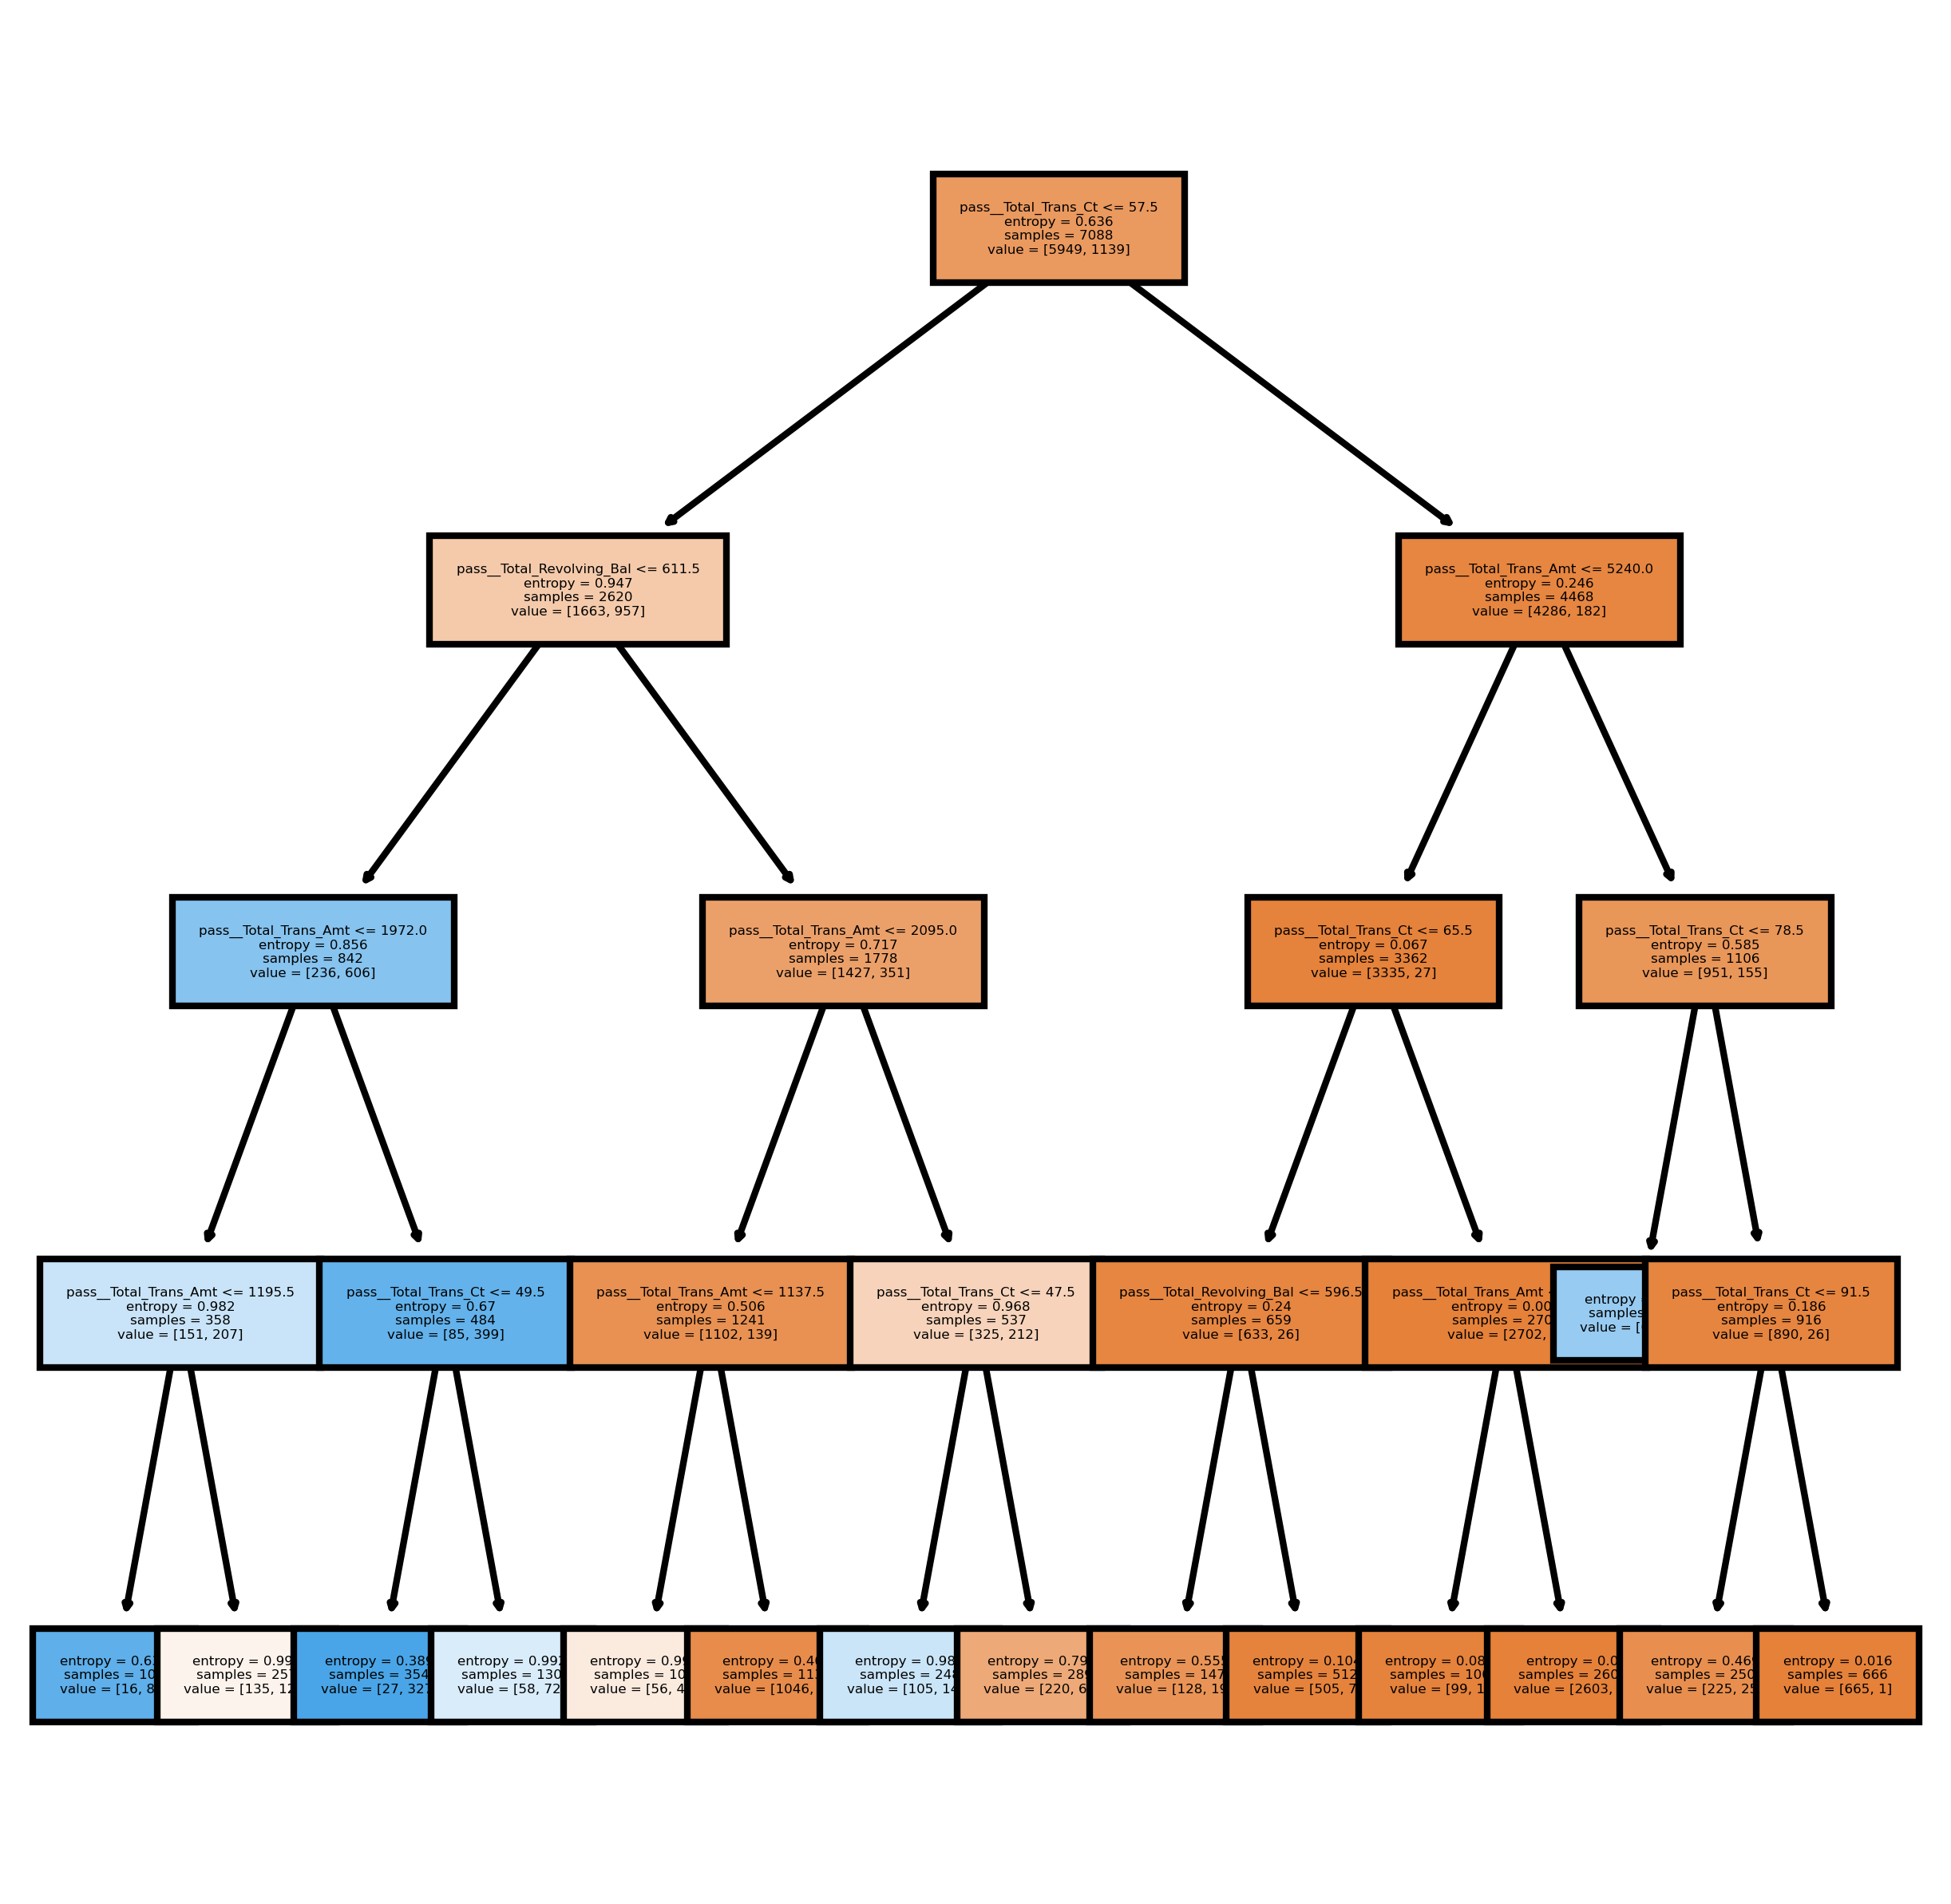

In [33]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=300)

tree.plot_tree(final_model.named_steps['trf3'],feature_names=pipe[:-1].get_feature_names_out(),fontsize=2,
           filled = True);
plt.savefig('Dtree_churn.png')

In [34]:
#feature selection using extratreesclassifier
from sklearn.ensemble import ExtraTreesClassifier
trf_et = ExtraTreesClassifier(random_state=42)

In [35]:
pipe_2 = Pipeline([
('trf1',trf1),
#('trf2',trf2), #remove SelectKbest feature selection
('trf_et',trf_et)
])

In [36]:
df_train_data

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,MOB_lbl,Ina_12_cnt_lbl,Credit_Limit_lbl,util_lbl,Trans_Amt_lbl,Trans_Ct_lbl
8948,44,F,3,1.0,Married,1.0,Blue,36,2,3,...,7632,95,0.532,0.275,24-36,<=3,5-10k,0.2-0.5,5-12.5k,50-100
6665,39,F,1,3.0,Single,0.0,Blue,34,3,1,...,4809,87,0.740,0.873,24-36,<=3,0-5k,>0.5,0-5k,50-100
7119,52,M,1,0.0,Married,4.0,Blue,36,4,2,...,4286,72,0.636,0.107,24-36,<=3,10-15k,0-0.2,0-5k,50-100
2257,34,M,0,3.0,Married,2.0,Blue,17,4,1,...,1868,43,0.344,0.793,<=24,<=3,0-5k,>0.5,0-5k,0-50
3461,47,M,5,6.0,Single,1.0,Blue,36,3,1,...,4252,70,0.591,0.150,24-36,<=3,5-10k,0-0.2,0-5k,50-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,47,F,5,0.0,Married,1.0,Blue,40,5,1,...,4742,79,0.837,0.678,>36,<=3,0-5k,>0.5,0-5k,50-100
6147,46,F,4,2.0,Married,0.0,Blue,30,3,1,...,5103,83,0.844,0.000,24-36,<=3,5-10k,0-0.2,5-12.5k,50-100
8858,52,F,1,2.0,Married,1.0,Blue,35,1,3,...,7847,65,0.857,0.522,24-36,<=3,0-5k,>0.5,5-12.5k,50-100
9144,39,M,2,4.0,Married,3.0,Blue,26,1,2,...,7786,81,0.929,0.000,24-36,<=3,0-5k,0-0.2,5-12.5k,50-100


In [37]:
df = pipe_2.fit(df_train_data,df_train_target)
df

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('pass', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f94a41064c0>),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f94880661c0>)])),
                ('trf_et', ExtraTreesClassifier(random_state=42))])

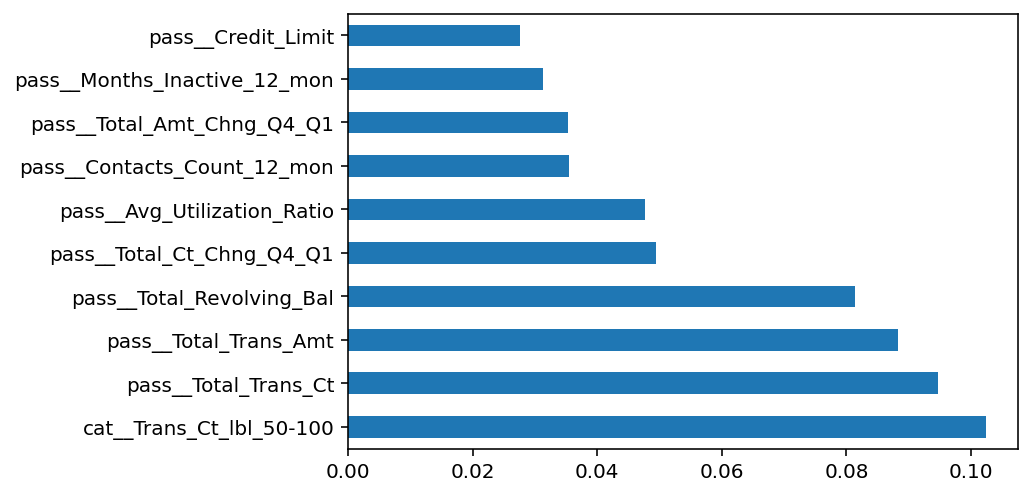

In [38]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(pipe_2.named_steps['trf_et'].feature_importances_,
                             index=pipe_2[:-1].get_feature_names_out())
features_selected=feat_importances.nlargest(10)
features_selected.plot(kind='barh')
plt.show()

In [39]:
feat_importances.sort_values(ascending=False)*100

cat__Trans_Ct_lbl_50-100           10.238661
pass__Total_Trans_Ct                9.467296
pass__Total_Trans_Amt               8.822580
pass__Total_Revolving_Bal           8.143811
pass__Total_Ct_Chng_Q4_Q1           4.945253
pass__Avg_Utilization_Ratio         4.769062
pass__Contacts_Count_12_mon         3.539982
pass__Total_Amt_Chng_Q4_Q1          3.525976
pass__Months_Inactive_12_mon        3.123433
pass__Credit_Limit                  2.760926
cat__Total_Relationship_Count_2     2.723342
pass__Avg_Open_To_Buy               2.672995
cat__Trans_Amt_lbl_5-12.5k          2.471691
pass__Customer_Age                  2.364489
cat__Gender_M                       2.191135
pass__Months_on_book                2.155164
pass__Education_Level               1.976476
pass__Income_Category               1.944521
cat__Marital_Status_Married         1.491820
cat__MOB_lbl_>36                    1.275273
cat__Total_Relationship_Count_6     1.273681
cat__Total_Relationship_Count_4     1.168816
cat__Marit

In [40]:
features_selected

cat__Trans_Ct_lbl_50-100        0.102387
pass__Total_Trans_Ct            0.094673
pass__Total_Trans_Amt           0.088226
pass__Total_Revolving_Bal       0.081438
pass__Total_Ct_Chng_Q4_Q1       0.049453
pass__Avg_Utilization_Ratio     0.047691
pass__Contacts_Count_12_mon     0.035400
pass__Total_Amt_Chng_Q4_Q1      0.035260
pass__Months_Inactive_12_mon    0.031234
pass__Credit_Limit              0.027609
dtype: float64

In [41]:
collist=features_selected.index

df_train_selected = pd.DataFrame(trf1.fit_transform(df_train_data),
                                 columns=trf1.get_feature_names_out()).loc[:,collist]
#create a new model with features selected
df = trf3.fit(df_train_selected,df_train_target)
df

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=100,
                       random_state=42)

In [42]:
#process Test data
df_test_selected = pd.DataFrame(trf1.fit_transform(df_test_data),
                                 columns=trf1.get_feature_names_out()).loc[:,collist]

In [47]:
#Measure Accuracy of pipeline model
y_pred = df.predict(df_test_selected)
from sklearn.metrics import accuracy_score
accuracy_score(df_test_target,y_pred)
#91.9%

0.9190523198420533

In [44]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(df, df_train_selected, df_train_target, cv=5, scoring='accuracy').mean()
#90.1%

0.9084376396626498

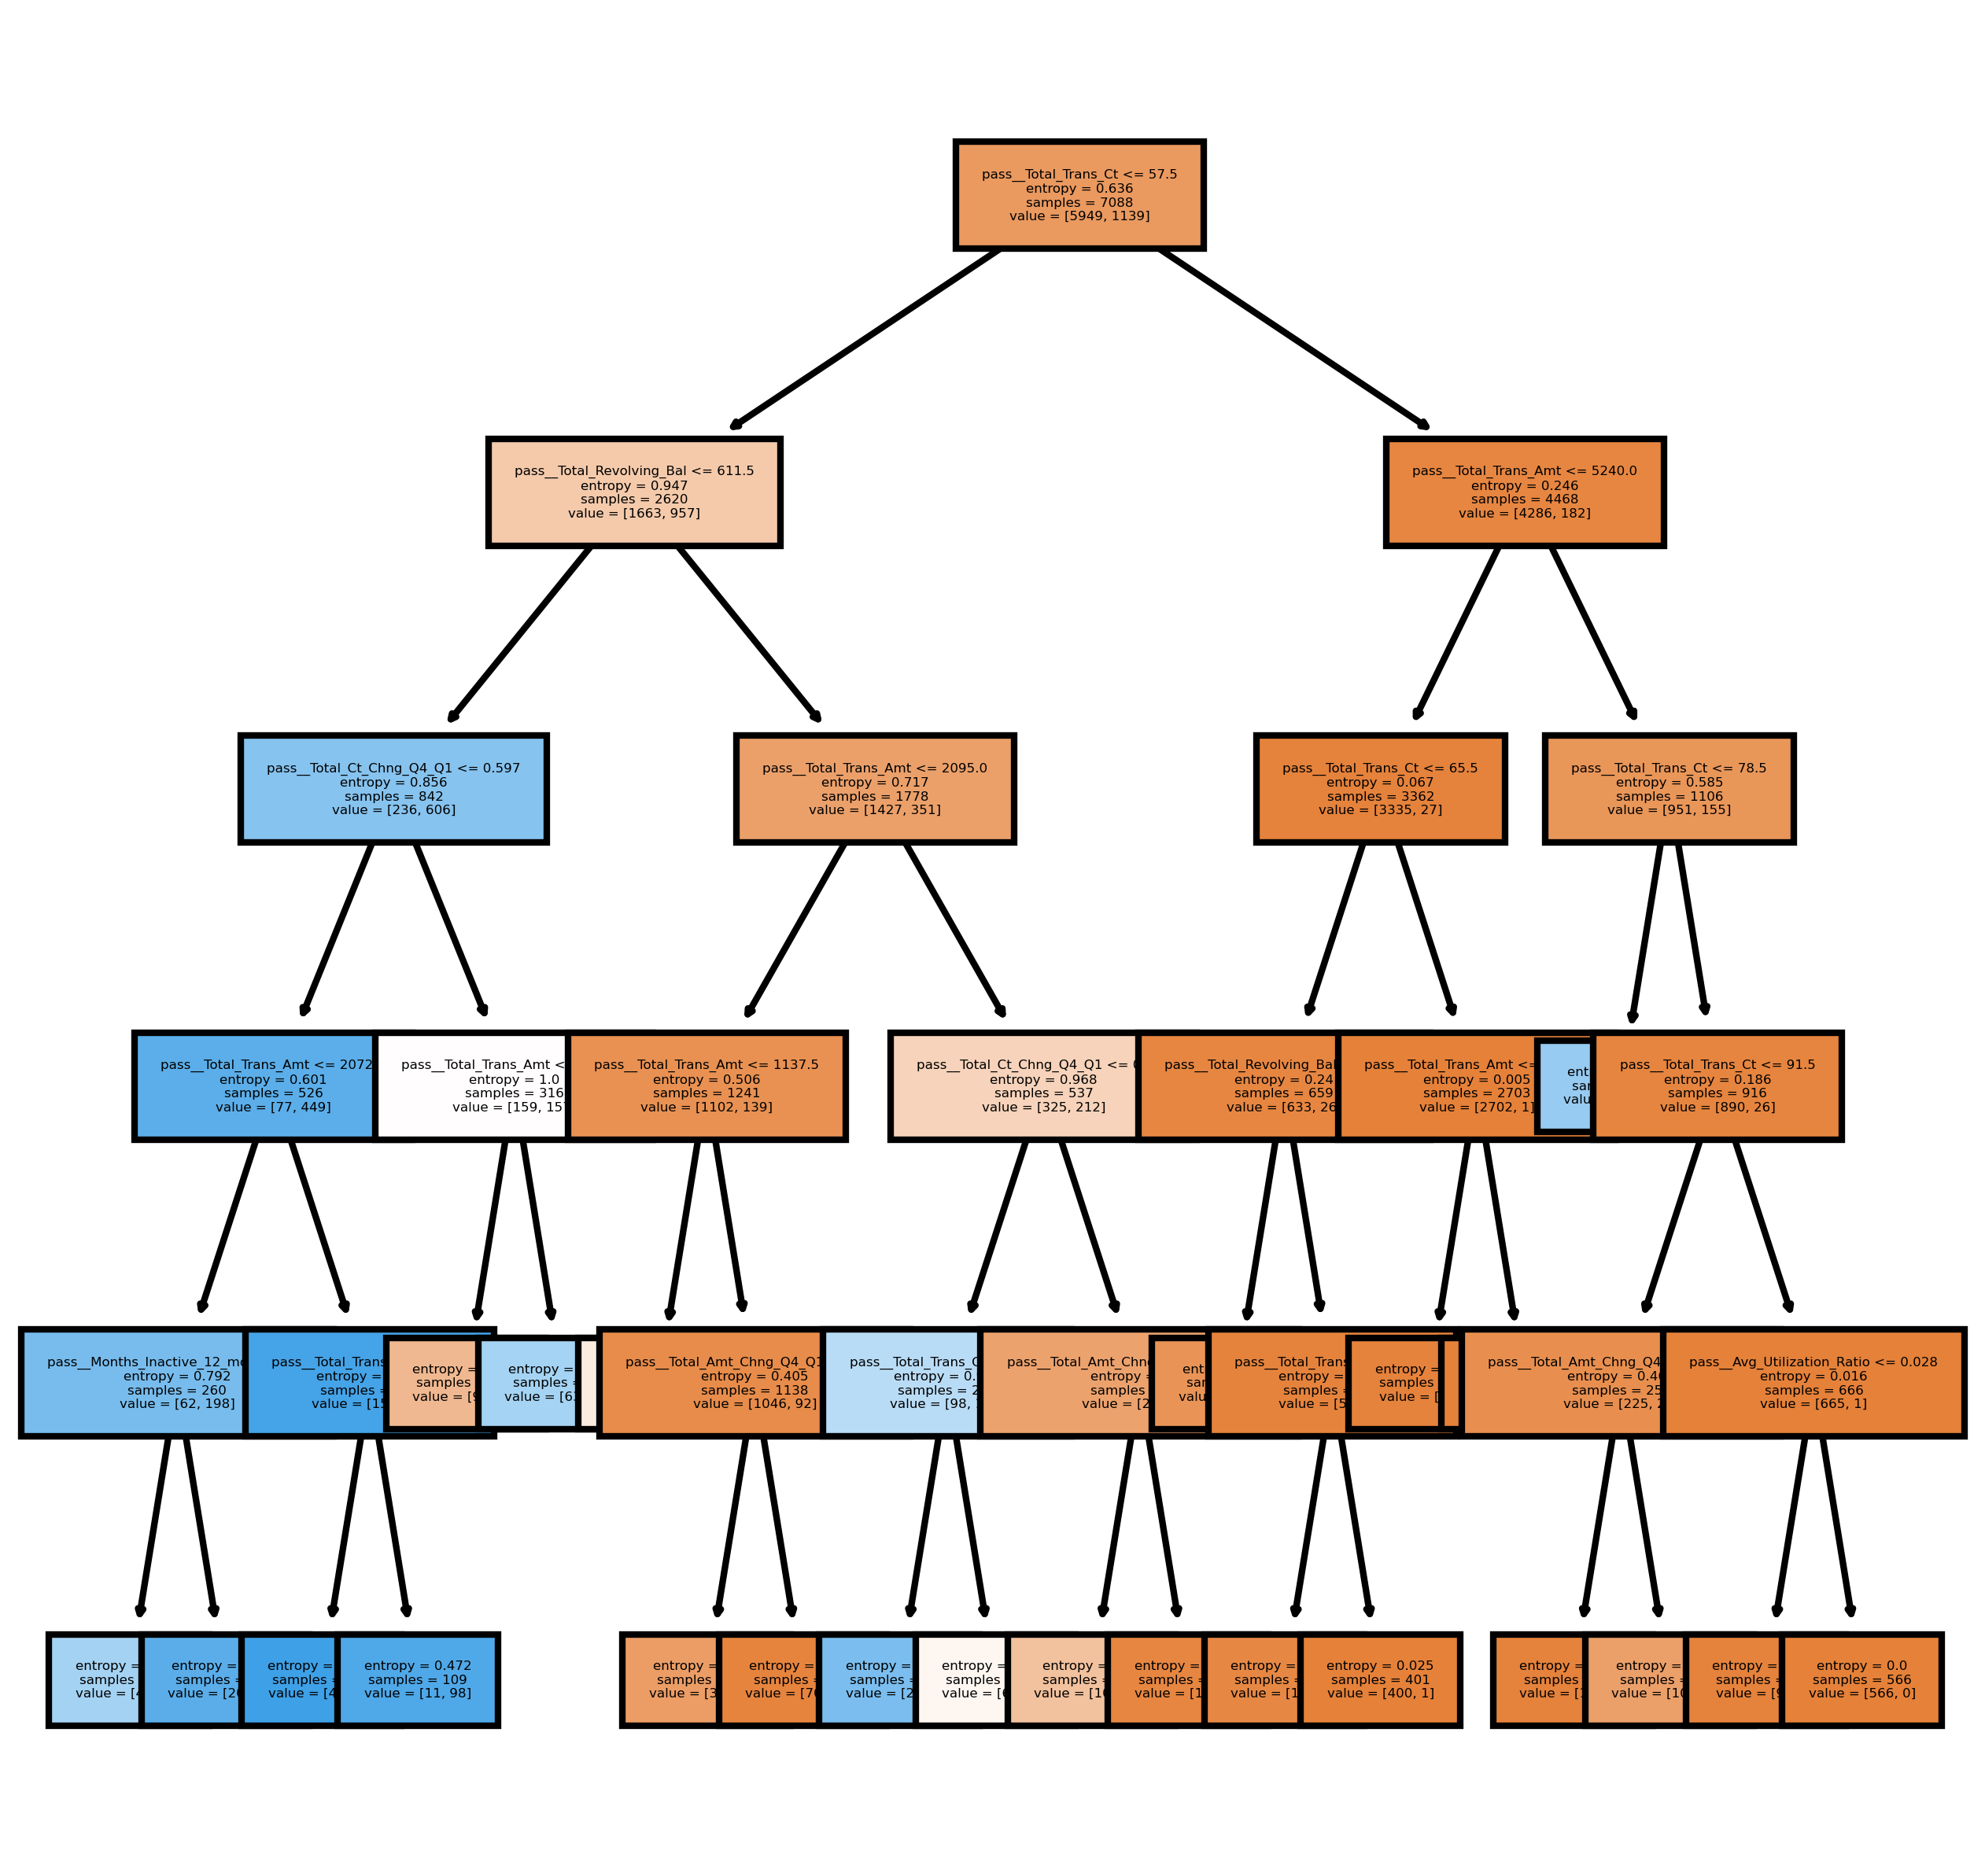

In [45]:
#visualize the tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=300)

tree.plot_tree(df,feature_names=collist,fontsize=2,
           filled = True);
plt.savefig('Dtree_churn_featureselected.png')

# Step 5) Model selection and Model Accuracy

In [70]:
#Libraries for measuring model accuracy
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score,f1_score,fbeta_score,plot_precision_recall_curve,roc_curve
from sklearn.metrics import auc,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,recall_score,precision_score

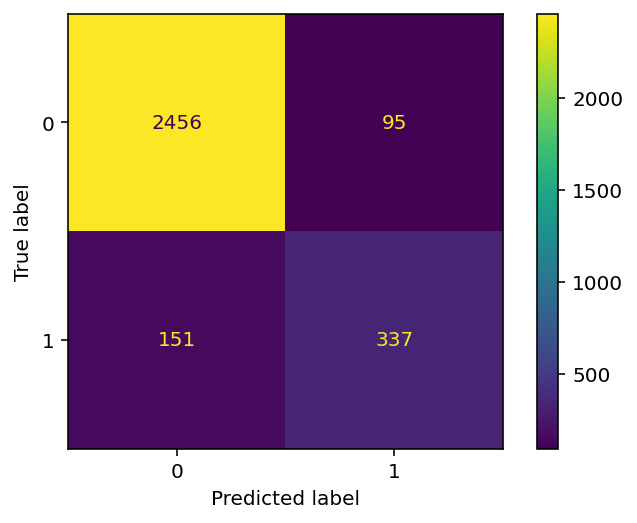

In [50]:
# Accuracy measures of current prediction(decision tree model)
#1)confusion matrix
ConfusionMatrixDisplay.from_predictions(df_test_target,y_pred)

In [64]:
TP = 337
FP = 95 
TN = 2456
FN = 151

FPR_F1_err = 100*FP/(FP+TN)
FNR_F2_err = 100*FN/(FN+TP)
precision = 100*TP/(TP+FP)
Recall = 100*TP/(TP+FN)
Accuracy = 100*(TP+TN)/(TP+FP+TN+FN)
F1_score = 2*precision*Recall/(precision+Recall)


print(f'1. FPR (F1 error) ={FPR_F1_err:0.2f} %')
print(f'2. FNR (F2 error) ={FNR_F2_err:0.2f}%')
print(f'3. Recall/TPR/Sensitivity -model reach(how many of the positives was your model able to capture?)={Recall:0.2f}%')
print(f'4. Precision-model accuracy(how accurate is your prediction?) ={precision:0.2f}%')
print(f'5. Accuracy(ok for a balanced dataset) = {Accuracy:0.2f}%')
print(f'6. F1-score (HM of Precision and Recall,equal weight to P and R) = {F1_score:0.2f}%')

1. FPR (F1 error) =3.72 %
2. FNR (F2 error) =30.94%
3. Recall -model reach(how many of the positives was your model able to capture?)=69.06%
4. Precision-model accuracy(how accurate is your prediction?) =78.01%
5. Accuracy(ok for a balanced dataset) = 91.91%
6. F1-score (HM of Precision and Recall,equal weight to P and R) = 73.26%


### The F2 error is high at 30%. Identifies only 337/488 churn customers

In [75]:
#From sklearn.metrics library functions
accuracy_score(df_test_target,y_pred),precision_score(df_test_target,y_pred),recall_score(df_test_target,y_pred),f1_score(df_test_target,y_pred) 

(0.9190523198420533,
 0.7800925925925926,
 0.6905737704918032,
 0.7326086956521738)

In [66]:
precision_score(df_test_target,y_pred)

0.7800925925925926

In [78]:
#plot ROC Curve
from sklearn.metrics import RocCurveDisplay,roc_auc_score,PrecisionRecallDisplay


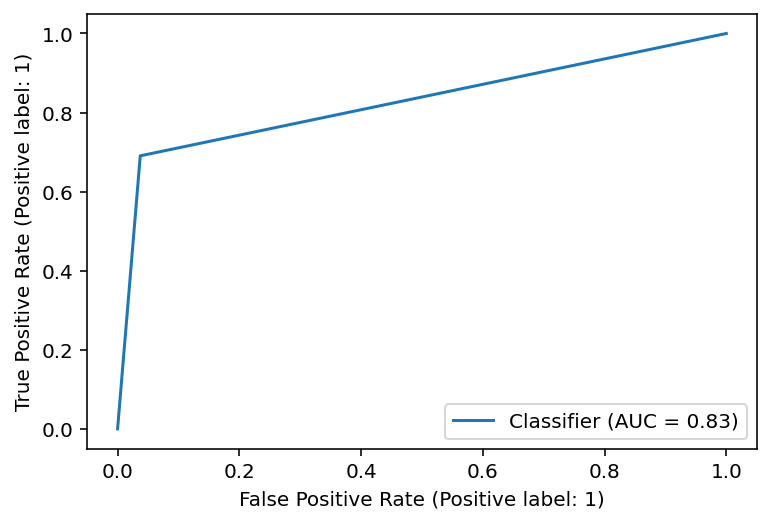

In [74]:
#sensitivity (precision,TPR) vs specificity(1-FPR)
RocCurveDisplay.from_predictions(df_test_target,y_pred)

In [77]:
roc_auc_score(df_test_target,y_pred)
# 83% AUC score

0.82666673628471

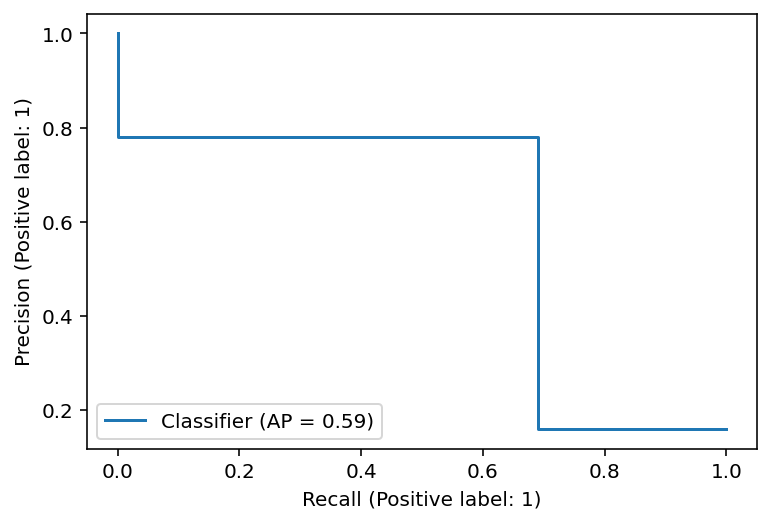

In [79]:
PrecisionRecallDisplay.from_predictions(df_test_target,y_pred)

### Try different classification models to see if they perform better than our model
Logistic Regression
Support Vector Machines
Naive Bayes